In [58]:
import pandas as pd
import numpy as np
import xarray as xr
import requests
%matplotlib inline
import matplotlib.pylab as plt
from scipy.interpolate import griddata
from cartopy import config
import cartopy.crs as ccrs
from shapely.geometry import Polygon
import shapely.geometry as geometry
from geojson import Polygon
import pymongo
import multiprocessing as mp
from numpy import array_split
from datetime import datetime
from datetime import timedelta
import time
import pdb
from shapely.ops import cascaded_union, polygonize
from scipy.spatial import Delaunay
from descartes import PolygonPatch
import numpy as np
import math

In [2]:
def get_ar_by_date(dateStr):
    url = 'http://localhost:3000/arShapes/findByDate?date={}'.format(dateStr)
    resp = requests.get(url)
    # Consider any status other than 2xx an error
    if not resp.status_code // 100 == 2:
        return "Error: Unexpected response {}".format(resp)
    profile = resp.json()
    return profile

In [74]:
date = '2010-01-01T00:00:00Z'
def make_year_dates(year):
    dates =  pd.date_range(start='1/1/'+str(year), end='1/1/'+str(year+1), freq='3H') 
    return dates[:-1]

def test_selection_profiles(startDate, endDate, shape, _id, pnt=None):
    "sends out AR _id if query failed, otherwise, true."
    baseURL = 'http://localhost:3000/selection/profiles/map'
    startDateQuery = '?startDate=' + startDate
    endDateQuery = '&endDate=' + endDate
    shapeQuery = '&shape='+shape
    url = baseURL + startDateQuery + endDateQuery + shapeQuery
    resp = requests.get(url)
    if pnt:
        print(url)
    # Consider any status other than 2xx an error
    if not resp.status_code // 100 == 2:
        return _id
    else:
        return None
    
format_date_api = lambda date: datetime.strftime(date, "%Y-%m-%dT%H:%M:%SZ")


def transform_shape(shape):
    transformedShape= []
    for point in shape:
        lng = point[0] % 360
        if (lng < -180):
            lng = 180 + lng % 180;
        if (lng > 180):
            lng = -180 + lng % 180;
        tpoint = [lng, point[1]];
        transformedShape.append(tpoint);
    return([transformedShape])


def test_shapes(ars, startDate, endDate):
    failedArs = []
    for idx, ar in enumerate(ars):
        tshape = transform_shape(ar['geoLocation']['coordinates'])
        shape = str(tshape).replace(' ', '')
        fail_id = test_selection_profiles(startDate, endDate, shape, ar['_id'])
        if fail_id:
            failedArs.append(ar)
    return failedArs

In [7]:
year = 2010
dates = make_year_dates(year)

In [8]:
date = dates[0]
ars = get_ar_by_date(format_date_api(date))
ar = ars[2]

In [87]:
fa = []
nArTested = 0
for date in dates:
    startDate = format_date_api(date - timedelta(days=3))
    endDate = format_date_api(date + timedelta(days=3))
    ars = get_ar_by_date(format_date_api(date))
    failedArs = test_shapes(ars, startDate, endDate)
    if len(failedArs) > 0:
        fa += failedArs
    nArTested += len(ars)

In [88]:
print(len(fa)/float(nArTested))
df = pd.DataFrame(fa)
df.to_csv('failed_ars.csv')

0.022900227129042078


In [90]:
startDate

'2010-12-28T21:00:00Z'

In [89]:
def format_ars(ars):
    out = ars.copy()
    for ar in out:
        coords = ar['geoLocation']['coordinates']
        del ar['geoLocation']
        longs, lats = list(zip(*coords))
        ar['coords'] = coords
        ar['longs'] = list(longs)
        ar['lats'] = list(lats)
    return out
ffar = format_ars(fa)
arDf = pd.DataFrame(ffar)

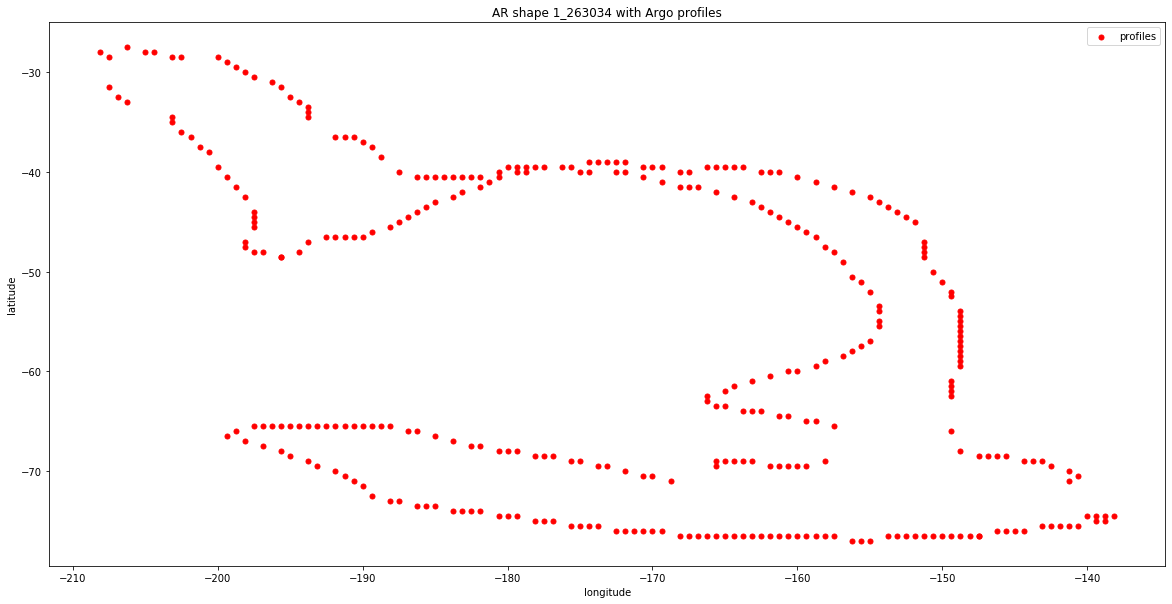

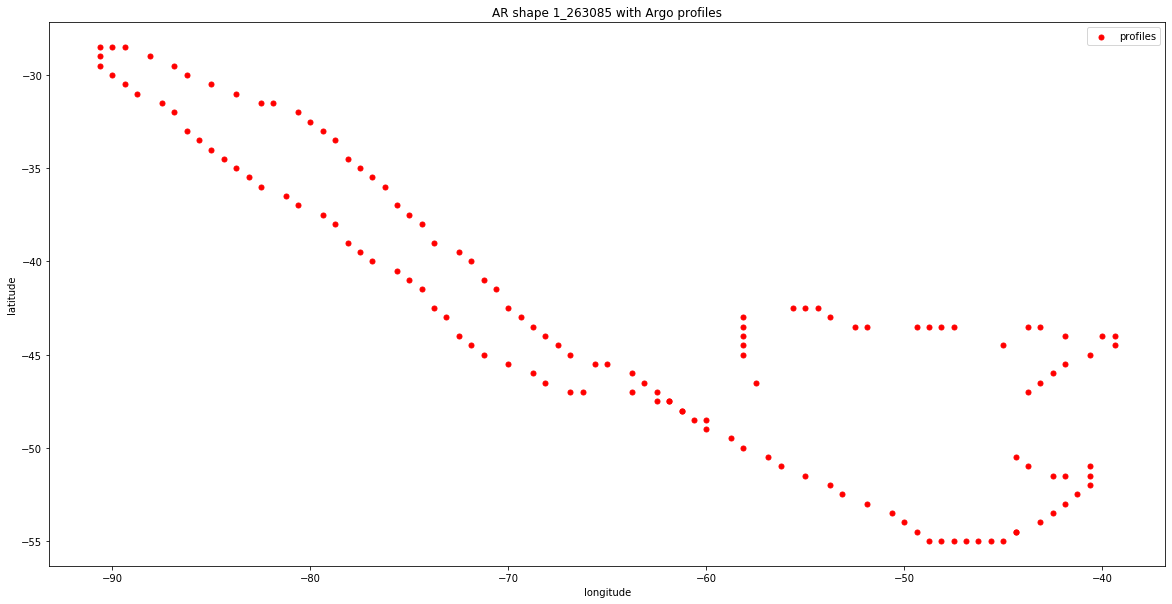

In [56]:
def plot_profiles_and_ar(lons, lats, id):
    fig = plt.figure(figsize=(20,10))
    axes = plt.axes()
    axes.scatter(lons,lats,marker='o',c='r',s=25)
    axes.set_title('AR shape {} with Argo profiles'.format(id))
    axes.set_ylabel('latitude')
    axes.set_xlabel('longitude')
    axes.legend(['profiles', 'ar shape'])
    return fig

for row in arDf.itertuples():
    fig = plot_profiles_and_ar(row.longs, row.lats, row.id)

# Attemp to fix

'pinch points' ie, areas where there the shape has no area cause errors )when querying shapes.

Instead of using the grid point centroid, we instead replace the outer hull with the gridded squares, so that there are no more pinch points (hopefully)

Diagonal pinch points still pose a problem

In [ ]:
def alpha_shape(points, alpha):
    """
    http://blog.thehumangeo.com/2014/05/12/drawing-boundaries-in-python/
    Compute the alpha shape (concave hull) of a set
    of points.
    @param points: Iterable container of points.
    @param alpha: alpha value to influence the
        gooeyness of the border. Smaller numbers
        don't fall inward as much as larger numbers.
        Too large, and you lose everything!
    """
    if len(points) < 4:
        # When you have a triangle, there is no sense
        # in computing an alpha shape.
        return geometry.MultiPoint(list(points)).convex_hull
    def add_edge(edges, edge_points, coords, i, j):
        """
        Add a line between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            return
        edges.add( (i, j) )
        edge_points.append(coords[ [i, j] ])

    coords = np.array([point.coords[0] for point in points])
    tri = Delaunay(coords)
    edges = set()
    edge_points = []
    # loop over triangles:
    # ia, ib, ic = indices of corner points of the
    # triangle
    for ia, ib, ic in tri.vertices:
        pa = coords[ia]
        pb = coords[ib]
        pc = coords[ic]
        # Lengths of sides of triangle
        aa = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
        bb = math.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
        cc = math.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)
        # Semiperimeter of triangle
        ss = (aa + bb + cc)/2.0
        # Area of triangle by Heron's formula
        areaSquared = ss*(ss-aa)*(ss-bb)*(ss-cc)
        if areaSquared < 0: # handles roundoff
            continue
        area = math.sqrt(areaSquared)
        try:
            area = math.sqrt(ss*(ss-aa)*(ss-bb)*(ss-cc))
        except ValueError:
            pdb.set_trace()
            continue
        if area == 0:
            continue
        circum_r = aa*bb*cc/(4.0*area)
        # Here's the radius filter.
        #print circum_r
        if circum_r < 1.0/alpha:
            add_edge(edges, edge_points, coords, ia, ib)
            add_edge(edges, edge_points, coords, ib, ic)
            add_edge(edges, edge_points, coords, ic, ia)
    m = geometry.MultiLineString(edge_points)
    triangles = list(polygonize(m))
    concave_hull = cascaded_union(triangles)
    return concave_hull, edge_points

def make_square(point, dx, dy):
    isNeg = [ ( x > 0, y > 0) for x in range(0,2) for y in range(0, 2) ]
    sign = lambda x: 1 * x + -1 * (not x)
    square = [ (point[0] + dx/2. * sign(sx), point[1] + dy/2. * sign(sy)) for (sx, sy) in isNeg]
    return square
def plot_polygon(polygon):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    margin = .3
    x_min, y_min, x_max, y_max = polygon.bounds
    ax.set_xlim([x_min-margin, x_max+margin])
    ax.set_ylim([y_min-margin, y_max+margin])
    patch = PolygonPatch(polygon, fc='#999999',
                         ec='#000000', fill=True,
                         zorder=-1)
    ax.add_patch(patch)
    return fig

def get_lons_lats_from_concave_hull(squarePoints, alpha=.5, buffer=None):
    points = [geometry.Point(xy) for xy in squarePoints]
    concave_hull, edge_points = alpha_shape(points, alpha=alpha)
    if isinstance(concave_hull, geometry.multipolygon.MultiPolygon):
        lat, lon = [], []
        for poly in concave_hull:
            if buffer:
                plon, plat = poly.buffer(buffer).exterior.coords.xy
            else:
                plon, plat = poly.exterior.coords.xy
            lat.extend(plat)
            lon.extend(plon)
    else:
        if buffer:
            lon, lat = concave_hull.buffer(buffer).exterior.coords.xy
        else:
            lon, lat = concave_hull.exterior.coords.xy
    return (lon, lat)

dlon = 0.625
dlat = 0.5

In [ ]:
row.geoLocation['coordinates']

In [137]:
from time import sleep

In [147]:
second_fail = []
sDate = '2010-12-28T21:00:00Z'
eDate = '2010-12-29T21:00:00Z'
alpha = .45 # try to snip off skinny ends
buffer = None # add a .5 degree buffer around
for row in df.itertuples():
    #lats = row.lats
    #lons = row.longs
    #points = [ (lons[idx], lats[idx]) for idx in range(0, len(lats)) ]
    points = row.geoLocation['coordinates']
    
    squares = [ make_square(lnglat, dlon, dlat) for lnglat in points ]
    squarePoints = [item for sublist in squares for item in sublist]
    
    sLons, sLats = get_lons_lats_from_concave_hull(squarePoints, .7, buffer )

    #sLons, sLats = [[ i for i, j in squarePoints ], [ j for i, j in squarePoints ]] 
    #pc = geometry.MultiPoint(list(squarePoints))
    #fig = plot_profiles_and_ar(sLons, sLats, row.id)
    #convex_hull_polygon = pc.convex_hull
    #plot_polygon(convex_hull_polygon)

    sShape = str([[ [sLons[idx], sLats[idx]] for idx in range(0, len(sLons))]]).replace(' ', '')
    fail_id = test_selection_profiles(startDate, endDate, sShape, row.id, False)

    if fail_id:
        second_fail.append(fail_id)
    #sleep(1)
    

In [146]:
print(df.shape)
print(len(second_fail))

(978, 6)
607


In [108]:
secondDf = df[ df['_id'].isin(second_fail)]

In [110]:
secondDf.to_csv('second_round_failed_ars.csv')

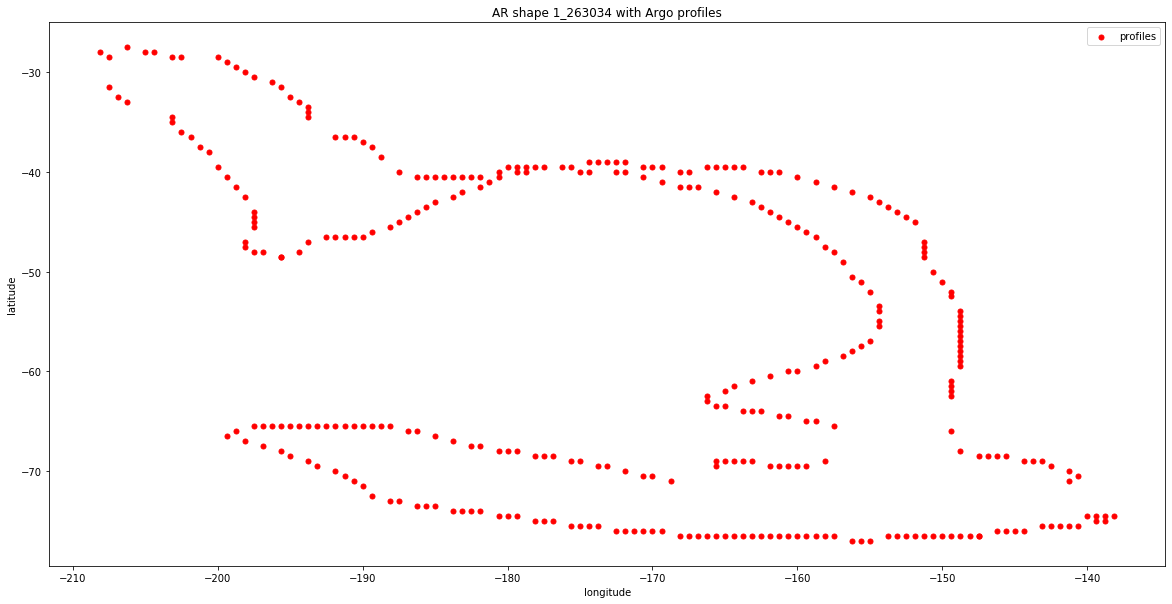

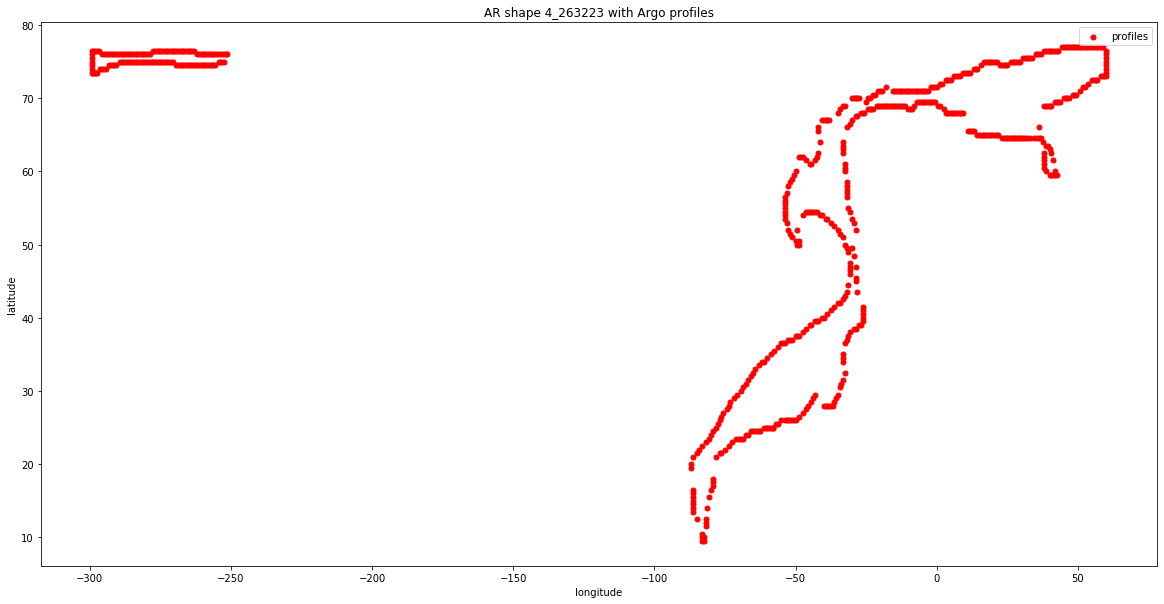

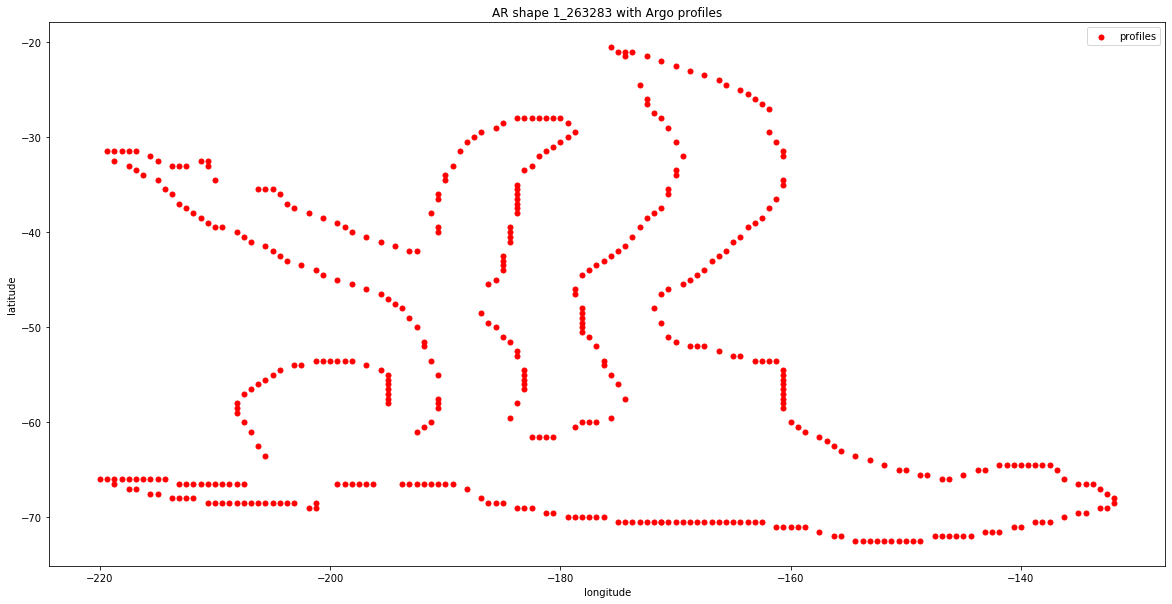

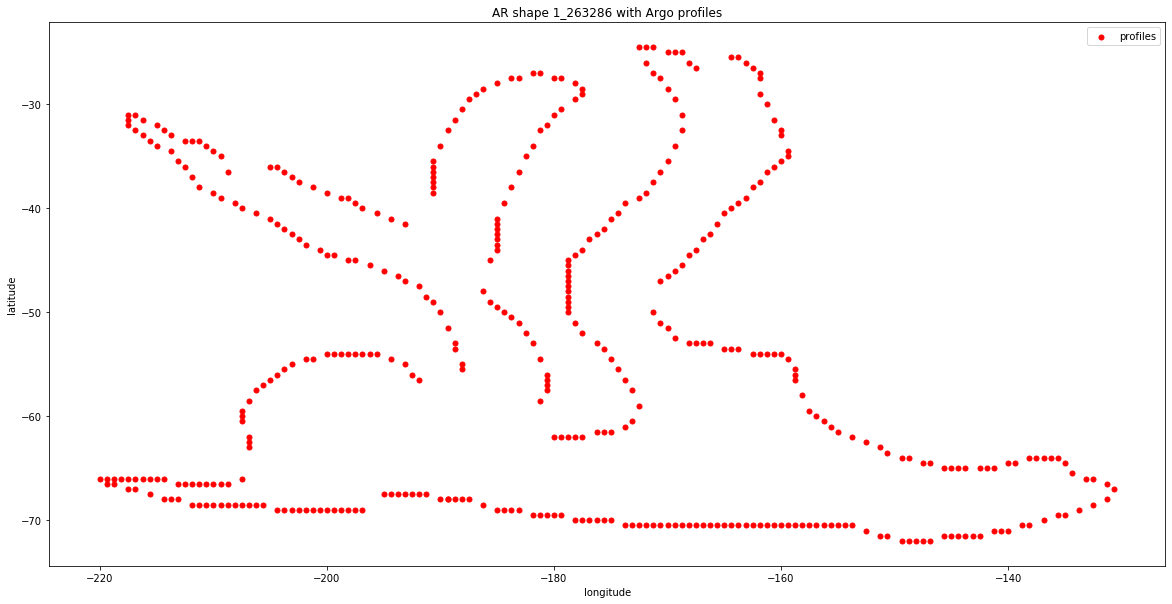

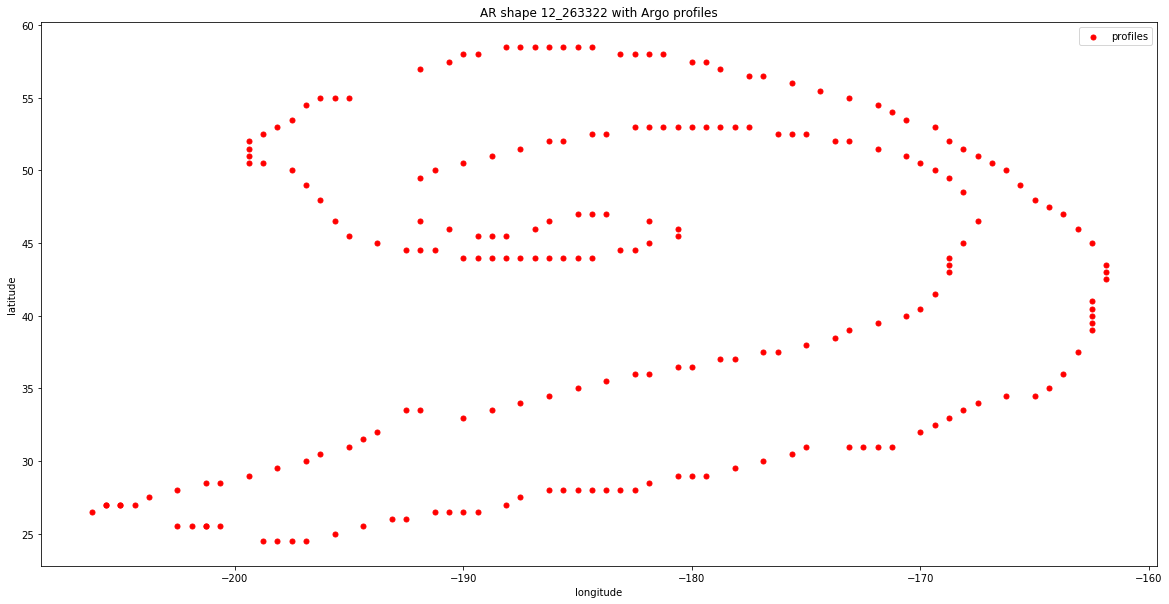

In [119]:
for row in secondDf.head().itertuples():
    points = row.geoLocation['coordinates']
    lons, lats = [[ i for i, j in points ], [ j for i, j in points ]]
    fig = plot_profiles_and_ar(lons, lats, row.id)

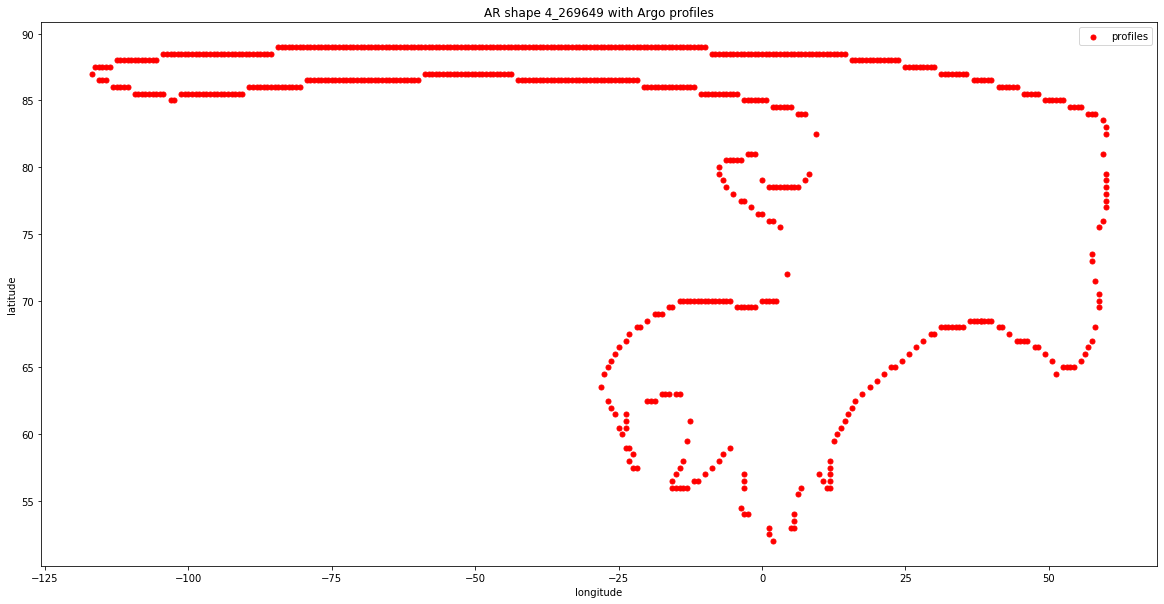

In [118]:
fig = plot_profiles_and_ar(lons, lats, row.id)